### Official Websites (Examples)
https://bashtage.github.io/linearmodels/panel/index.html

### Official Github (Examples)

https://github.com/bashtage/linearmodels/blob/main/README.md

https://bashtage.github.io/linearmodels/panel/examples/examples.html

## 1. Wage (Wage ~ Experience)

In [1]:
from linearmodels.panel import PanelOLS
from linearmodels.datasets import wage_panel
import statsmodels.api as sm
from linearmodels import BetweenOLS, FirstDifferenceOLS, PooledOLS
import pandas as pd

pd.set_option('display.float_format', lambda x:'%.7f' % x)

In [2]:
data = wage_panel.load()
data

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.1975400,1,9
1,13,1981,0,2,0,2320,0,14,1,1.8530600,4,9
2,13,1982,0,3,0,2940,0,14,0,1.3444620,9,9
3,13,1983,0,4,0,2960,0,14,0,1.4332130,16,9
4,13,1984,0,5,0,3071,0,14,0,1.5681250,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,8,0,2080,1,9,0,1.5918790,64,5
4356,12548,1984,0,9,0,2080,1,9,1,1.2125430,81,5
4357,12548,1985,0,10,0,2080,1,9,0,1.7659620,100,5
4358,12548,1986,0,11,0,2080,1,9,1,1.7458940,121,5


In [3]:
# data.to_csv("wage_panel.csv")

In [4]:
# Convert the year into categorical type
year = pd.Categorical(data.year)

data = data.set_index(['nr','year'])

In [5]:
data["year"] = year
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4360 entries, (13, 1980) to (12548, 1987)
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   black       4360 non-null   int64   
 1   exper       4360 non-null   int64   
 2   hisp        4360 non-null   int64   
 3   hours       4360 non-null   int64   
 4   married     4360 non-null   int64   
 5   educ        4360 non-null   int64   
 6   union       4360 non-null   int64   
 7   lwage       4360 non-null   float64 
 8   expersq     4360 non-null   int64   
 9   occupation  4360 non-null   int64   
 10  year        4360 non-null   category
dtypes: category(1), float64(1), int64(9)
memory usage: 378.9 KB


In [6]:
print(wage_panel.DESCR)
print(data.head())


F. Vella and M. Verbeek (1998), "Whose Wages Do Unions Raise? A Dynamic Model
of Unionism and Wage Rate Determination for Young Men," Journal of Applied
Econometrics 13, 163-183.

nr                       person identifier
year                     1980 to 1987
black                    =1 if black
exper                    labor market experience
hisp                     =1 if Hispanic
hours                    annual hours worked
married                  =1 if married
educ                     years of schooling
union                    =1 if in union
lwage                    log(wage)
expersq                  exper^2
occupation               Occupation code

         black  exper  hisp  hours  married  educ  union     lwage  expersq  \
nr year                                                                       
13 1980      0      1     0   2672        0    14      0 1.1975400        1   
   1981      0      2     0   2320        0    14      1 1.8530600        4   
   1982      0    

### 1.1 Descriptive Statistics

In [7]:
data.describe()

,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
count,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000,4360.0000000
mean,0.1155963,6.5146789,0.1559633,2191.2573394,0.4389908,11.7669725,0.2440367,1.6491472,50.4247706,4.9885321
std,0.3197769,2.8258735,0.3628622,566.3523011,0.4963208,1.7461815,0.4295639,0.5326094,40.7819906,2.3199775
min,0.0000000,0.0000000,0.0000000,120.0000000,0.0000000,3.0000000,0.0000000,-3.5790790,0.0000000,1.0000000
25%,0.0000000,4.0000000,0.0000000,2040.0000000,0.0000000,11.0000000,0.0000000,1.3507170,16.0000000,4.0000000
50%,0.0000000,6.0000000,0.0000000,2080.0000000,0.0000000,12.0000000,0.0000000,1.6711430,36.0000000,5.0000000
75%,0.0000000,9.0000000,0.0000000,2414.2500000,1.0000000,12.0000000,0.0000000,1.9910865,81.0000000,6.0000000
max,1.0000000,18.0000000,1.0000000,4992.0000000,1.0000000,16.0000000,1.0000000,4.0518600,324.0000000,9.0000000


In [8]:
print(data.columns)

Index(['black', 'exper', 'hisp', 'hours', 'married', 'educ', 'union', 'lwage',
       'expersq', 'occupation', 'year'],
      dtype='object')


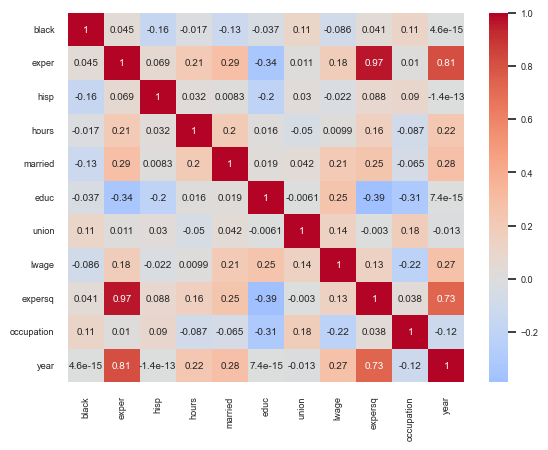

In [9]:
# Draw the Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# set the font size of the heatmap
sns.set(font_scale=0.6)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

### 1.2 Basic Regression (Pooled OLS) on Panel Data

- PooledOLS is just plain OLS that understands that various panel data structures. It is useful as a base model

$$
y_{it} = \beta x_{it} + (\alpha + \epsilon_{it})
$$

In [10]:
# Determine the exogenous variables
exog_vars = ["black", "hisp", "exper", "expersq", "married", "educ", "union", "year"]
exog = sm.add_constant(data[exog_vars])
model = PooledOLS(data.lwage, exog)
pooled_res = model.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1893
Estimator:                  PooledOLS   R-squared (Between):              0.2066
No. Observations:                4360   R-squared (Within):               0.1692
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.1893
Time:                        21:43:36   Log-likelihood                   -2982.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      72.459
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(14,4345)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             72.459
                            

### 1.3 Entity Effect

When modeling panel data it is common to consider models beyond what OLS will efficiently estimate. The most common are error component models which add an additional term to the standard OLS model,

$$
y_{it} = \beta x_{it} + \alpha_i + \epsilon_{it}
$$

where $\alpha_i$ affects all values of entity i. 

When the $\alpha_i$ are uncorrelated with the regressors in $x_{it}$ , 

a random effects model can be used to efficiently estimate parameters of this model.

#### 1.3.1 Random Effect

The random effects model is <font color = "red"> virtually identical to the pooled OLS model </font>  <font color = "orange">except that is accounts for the structure of the model and so is more efficient </font>. Random effects uses a quasi-demeaning strategy which subtracts the time average of the within entity values to account for the common shock.

In [11]:
from linearmodels import RandomEffects

mod = RandomEffects(data.lwage, exog)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1806
Estimator:              RandomEffects   R-squared (Between):              0.1853
No. Observations:                4360   R-squared (Within):               0.1799
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.1828
Time:                        21:43:36   Log-likelihood                   -1622.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      68.409
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(14,4345)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             68.409
                            

- The model fit is fairly similar, although the return to experience has changed substantially, as has its significance. 

- <font color = "orange"> This is partially explainable by the inclusion of the year dummies </font> which will fit the trend in experience and so only the cross-sectional differences matter. 

- The quasi-differencing in the random effects estimator depends on a quantity that depends on the relative variance of the idiosyncratic shock and the common shock. 

- This can be accessed using variance_decomposition.

In [12]:
print(re_res.variance_decomposition)
re_res.theta.head()

Effects                  0.1069460
Residual                 0.1233236
Percent due to Effects   0.4644382
Name: Variance Decomposition, dtype: float64


,theta
nr,
13,0.6450593
17,0.6450593
18,0.6450593
45,0.6450593
110,0.6450593


The coefficient $\theta_i$ determines how much demeaning takes place. When this value is 1, the RE model reduces to the pooled model since this occurs when there is no variance in the effects. When panels are unbalanced it will vary across entities, but in this balanced panel all values are the same.

#### 1.3.2 Between Estimator 

The between estimator is an alternative, usually less efficient estimator, can can be used to estimate model parameters. 

It is particular simple since it first computes the time averages of y and x and then runs a simple regression using these averages.

The year dummies are dropped since the averaging removes differences due to the year. expersq was also dropped since it is fairly co-linear with exper. These results are broadly similar to the previous models.

In [13]:
exog_vars = ["black","hisp","exper","married","educ","union"]
exog = sm.add_constant(data[exog_vars])
mod = BetweenOLS(data.lwage, exog)
be_res = mod.fit()
print(be_res)

                         BetweenOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.2155
Estimator:                 BetweenOLS   R-squared (Between):              0.2155
No. Observations:                 545   R-squared (Within):               0.1141
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.1686
Time:                        21:43:36   Log-likelihood                   -194.54
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      24.633
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                   F(6,538)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             24.633
                            

### 1.3.3 Entity effect
Entity effects are included by setting entity_effects=True. This is equivalent to including dummies for each entity. In this panel, this would add 545 dummy variables and estimation of the model would be considerably slower. PanelOLS does not actually use dummy variables and instead uses group-wise demeaning to achieve the same effec

In [14]:
exog_vars = ["expersq", "union", "married", "year"]
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lwage, exog, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1806
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):               0.1806
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.0807
Time:                        21:43:36   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      83.851
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(10,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             83.851
                            

### 1.3.4 Time Effect

Time effect can be added using time_effects=True. Here the time dummies are removed. Note that the core coefficients are identical. The only change is in the test statistic for poolability since not the “effects” include both entity and time, whereas before only entity were included.

In [15]:
exog_vars = ["expersq", "union", "married"]
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lwage, exog, entity_effects=True, time_effects=True)
fe_te_res = mod.fit()
print(fe_te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.2253
Time:                        21:43:36   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             27.959
                            

## 1.4 First Differences

First differencing is an alternative to using fixed effects when there might be correlation. When using first differences, time-invariant variables must be excluded. Additionally, only one linear time-trending variable can be included since this will look like a constant. This variable will soak up all time-trends in the data, and so interpretations of these variable can be challenging.

In [16]:
from linearmodels.panel import FirstDifferenceOLS

exog_vars = ["exper", "expersq", "union", "married"]
exog = data[exog_vars]
mod = FirstDifferenceOLS(data.lwage, exog)
fd_res = mod.fit()
print(fd_res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                  lwage   R-squared:                        0.0268
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.5491
No. Observations:                3815   R-squared (Within):               0.1763
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.5328
Time:                        21:43:36   Log-likelihood                   -2305.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.208
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(4,3811)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             26.208
                            

## 1.5 Comparing Models

Model results can be compared using *compare*. compare accepts lists of results, a dictionary of results where the key is interpreted as the model name.

In [17]:
from linearmodels.panel import compare

print(compare({"BE": be_res, "RE": re_res, "Pooled": pooled_res}))

                        Model Comparison                       
                                BE              RE       Pooled
---------------------------------------------------------------
Dep. Variable                lwage           lwage        lwage
Estimator               BetweenOLS   RandomEffects    PooledOLS
No. Observations               545            4360         4360
Cov. Est.               Unadjusted      Unadjusted   Unadjusted
R-squared                   0.2155          0.1806       0.1893
R-Squared (Within)          0.1141          0.1799       0.1692
R-Squared (Between)         0.2155          0.1853       0.2066
R-Squared (Overall)         0.1686          0.1828       0.1893
F-statistic                 24.633          68.409       72.459
P-value (F-stat)            0.0000          0.0000       0.0000
===================== ============ =============== ============
const                       0.2836          0.0234       0.0921
                          (1.5897)      

## 1.6 Covariance Options

### 1.6.1 Heteroskedasticity Robust Covariance
White”s robust covariance can be used by setting cov_type="robust. This estimator adds some robustness against certain types of specification issues but should not be used when using fixed effects (entity effects) since it is no longer robust. Instead a clustered covariance is required.

In [18]:
exog_vars = ["expersq", "married", "union"]
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lwage, exog, entity_effects=True, time_effects=True)
robust = mod.fit(cov_type="robust")
none = mod.fit()
print(robust)
print(compare({"Roubst": robust, "None": none}))


                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.2253
Time:                        21:43:37   Log-likelihood                   -1324.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             31.025
                            

## 1.6.2 Clustered by Entity

The usual variable to cluster are are entity or entity and time. The can be implemented using cov_type="clustered" and the additional keyword arguments cluster_entity=True and/or cluster_time=True.

In [19]:
clust_entity = mod.fit(cov_type="clustered", cluster_entity=True)
print(clust_entity)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.2253
Time:                        21:43:37   Log-likelihood                   -1324.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             18.496
                            

In [20]:
clust_entity_time = mod.fit(
    cov_type="clustered", cluster_entity=True, cluster_time=True
)
print(clust_entity_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.2253
Time:                        21:43:37   Log-likelihood                   -1324.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             23.126
                            

## 1.6.3 Use "OrderedDict" to compare the models

In [21]:
from collections import OrderedDict

res = OrderedDict()
res["Robust"] = robust
res["Entity"] = clust_entity
res["Entity - Time"] = clust_entity_time
print(compare(res))

                         Model Comparison                        
                               Robust        Entity Entity - Time
-----------------------------------------------------------------
Dep. Variable                   lwage         lwage         lwage
Estimator                    PanelOLS      PanelOLS      PanelOLS
No. Observations                 4360          4360          4360
Cov. Est.                      Robust     Clustered     Clustered
R-squared                      0.0216        0.0216        0.0216
R-Squared (Within)            -0.4809       -0.4809       -0.4809
R-Squared (Between)           -0.0052       -0.0052       -0.0052
R-Squared (Overall)           -0.2253       -0.2253       -0.2253
F-statistic                    27.959        27.959        27.959
P-value (F-stat)               0.0000        0.0000        0.0000
=====================     ===========   ===========   ===========
const                          1.8706        1.8706        1.8706
          

## 1.6.4 Other Clusters 
Other clusters can be used by directly passing integer arrays (1 or 2 columns, or a 1-d array) using the input clusters. This example clustered by occupation, which is probably not a reliable variable to cluster on since there are only 9 groups and the usual theory for clustered standard errors requires that the number of clusters is large.

In [22]:
clust_entity = mod.fit(cov_type="clustered", clusters=data.occupation)
print(data.occupation.value_counts())
print(clust_entity)

occupation
5    934
6    881
9    509
4    486
1    453
7    401
2    399
3    233
8     64
Name: count, dtype: int64
                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.2253
Time:                        21:43:37   Log-likelihood                   -1324.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                   

## 2. Grunfeld data 
using formulas to specify models

    invest  - Gross investment in 1947 dollars
    value   - Market value as of Dec. 31 in 1947 dollars
    capital - Stock of plant and equipment in 1947 dollars
    firm    - General Motors, US Steel, General Electric, Chrysler,
            Atlantic Refining, IBM, Union Oil, Westinghouse, Goodyear,
            Diamond Match, American Steel
    year    - 1935 - 1954

In [23]:
# Load data
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.to_csv('grunfeld.csv')

In [24]:
# reset the index
data = data.set_index(['firm','year'])

### PanelOLS with Entity Effects¶

Entity effects are specified using the special command EntityEffects. By default a constant is not included, and so if a constant is desired, 1+ should be included in the formula. When including effects, the model and fit are identical whether a constant is included or not.

In [25]:
### No Constant
mod = PanelOLS.from_formula("invest ~ value + capital + EntityEffects", data = data)
print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 invest   R-squared:                        0.7667
Estimator:                   PanelOLS   R-squared (Between):              0.8223
No. Observations:                 220   R-squared (Within):               0.7667
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8132
Time:                        21:43:37   Log-likelihood                   -1167.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      340.08
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,207)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             340.08
                            

In [26]:
### Add Constant
mod = PanelOLS.from_formula("invest ~ 1 + value + capital + EntityEffects", data = data)
print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 invest   R-squared:                        0.7667
Estimator:                   PanelOLS   R-squared (Between):              0.8193
No. Observations:                 220   R-squared (Within):               0.7667
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8071
Time:                        21:43:37   Log-likelihood                   -1167.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      340.08
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,207)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             340.08
                            

### PanelOLS with Entity Effects & Time Effects

Time effects can be similarly included using *TimeEffects*. In many models, time effects can be consistently estimated and so they could be equivalently included in the set of regressors using a categorical variable.

In [27]:
mod = PanelOLS.from_formula(
    "invest ~ 1 + value + capital + EntityEffects + TimeEffects", data = data
)
print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 invest   R-squared:                        0.7253
Estimator:                   PanelOLS   R-squared (Between):              0.7944
No. Observations:                 220   R-squared (Within):               0.7566
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.7856
Time:                        21:43:37   Log-likelihood                   -1153.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      248.15
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,188)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             248.15
                            

### Between OLS

In [28]:
mod = BetweenOLS.from_formula("invest ~ 1 + value + capital", data=data)
print(mod.fit())

                         BetweenOLS Estimation Summary                          
Dep. Variable:                 invest   R-squared:                        0.8644
Estimator:                 BetweenOLS   R-squared (Between):              0.8644
No. Observations:                  11   R-squared (Within):               0.4195
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.7616
Time:                        21:43:37   Log-likelihood                   -61.997
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      25.500
Entities:                          11   P-value                           0.0003
Avg Obs:                       20.000   Distribution:                     F(2,8)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             25.500
                            

### First Difference OLS

In [29]:
mod = FirstDifferenceOLS.from_formula("invest ~ value + capital", data=data)
print(mod.fit())

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                 invest   R-squared:                        0.4287
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.8643
No. Observations:                 209   R-squared (Within):               0.7539
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8461
Time:                        21:43:37   Log-likelihood                   -1071.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      77.679
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,207)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             77.679
                            

### Pooled OLS

The pooled OLS estimator is a special case of PanelOLS when there are no effects. It is effectively identical to OLS in statsmodels (or WLS) but is included for completeness.

In [30]:
mod = PooledOLS.from_formula("invest ~ 1 + value + capital", data = data)
print(mod.fit())

                          PooledOLS Estimation Summary                          
Dep. Variable:                 invest   R-squared:                        0.8179
Estimator:                  PooledOLS   R-squared (Between):              0.8426
No. Observations:                 220   R-squared (Within):               0.7357
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8179
Time:                        21:43:37   Log-likelihood                   -1301.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      487.28
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,217)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             487.28
                            